In [1]:
import jupyter

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.stats import skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox

from src.utils.system import boot
from src.defaults import RANDOM_SEEDS, TOP2_STOCK_BY_SECTOR
from tracker import OHLCV_DF, EpisodeTracker, EnvironmentTracker, AgentTracker



In [3]:
# Configuration ======================
excluded_tickers = sorted(['CEG', 'GEHC', 'GEV', 'KVUE', 'SOLV'])

config = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0
}

run_settings = {
    "excluded_tickers": excluded_tickers,
    "min_samples": 10,
    "cv_folds": 3,
    "lags": 5,
    "start_date": "2023-12-31",
    "end_date": "2025-05-01",
    "seed": 314,
    "episode_length": 50,
    "noise_feature_cols": ["return_1d", "volume"],
    "train_steps": 50_000,
    "lookback": 0,
    
}

# System Boot =======================
DEVICE = boot()



In [4]:
# Helper functions ====================
import numpy as np

def compute_returns_curve(curve):
    returns = np.diff(curve) / curve[:-1]
    return returns

def sharpe_ratio(returns, risk_free_rate=0.0):
    excess = returns - risk_free_rate
    return np.mean(excess) / (np.std(excess) + 1e-8)

def sortino_ratio(returns, risk_free_rate=0.0):
    returns = np.array(returns)
    excess = returns - risk_free_rate
    downside = excess[excess < 0]
    
    # Avoid division by zero: if no downside, assume very small downside deviation
    if len(downside) == 0:
        downside_std = 1e-8
    else:
        downside_std = np.std(downside)
    
    return np.mean(excess) / downside_std


def calmar_ratio(returns_curve):
    total_return = returns_curve[-1] / returns_curve[0] - 1
    drawdown = np.maximum.accumulate(returns_curve) - returns_curve
    max_drawdown = np.max(drawdown) / returns_curve[0]
    return total_return / (max_drawdown + 1e-8)

def central_tendency_difference (mean,median,std):
    return abs(mean-median)/(abs(std))

In [5]:
import os
import json
import hashlib
from collections import defaultdict
STORAGE_PATH = "data/experiments/episode_benchmark_engine/runs.csv"


EXCLUDED_TICKERS = sorted(["CEG", "GEHC", "GEV", "KVUE", "SOLV"])

CONFIG = {
    "regressor": "RandomForestRegressor",
    "n_estimators": 300,
    "random_state": 314,
    "transaction_cost": 0,
}
LOOKBACK = 0
EPISODE_LENGTH = 50

RUN_SETTINGS = {
    "excluded_tickers": EXCLUDED_TICKERS,
    "cv_folds": 3,
    "lags": 5,
    "seed": 314,
    'total_timesteps':50_000,
    "episode": {
        "episode_length": EPISODE_LENGTH,
        "lookback": LOOKBACK,
    },
    "environment": {
        "market_features": ["close", "price_change", "volume_change"],
        "version": "v2",
        "lookback": LOOKBACK,
        "episode_length": EPISODE_LENGTH,
        "transaction_cost": 0,
    },
    "agent": {
        "model_class": "PPO",
        "policy_class": "MlpPolicy",
        "config": {
            "verbose": 1,
            "ent_coef":0.1,
            "policy_kwargs": 
                {
                
                    "net_arch": [64, 64]
                    }
                },
    },
}


class EpisodeBenchmark:
    def __init__(
        self,
        tickers=["AAPL"],
        config=CONFIG,
        run_settings=RUN_SETTINGS,
        start_date="2024-01-01",
    ):
        self.ohlcv_df = OHLCV_DF.copy()
        self.tickers = tickers  # Force test with AAPL
        self.start_date = start_date


        self.config = CONFIG.copy()
        self.config.update(config)
        
        self.run_settings = RUN_SETTINGS.copy()
        self.run_settings.update(run_settings)
        self.run_settings['environment']['market_features'].sort()
        
        self.ep_tracker = EpisodeTracker()
        self.env_tracker = EnvironmentTracker()
        self.agent_tracker = AgentTracker()
        
        self.boot()
        
    def boot(self):
        if os.path.exists(STORAGE_PATH):
            self.completed_runs_df = pd.read_csv(STORAGE_PATH)

            self.completed_hashes = set(self.completed_runs_df["run_hash"].unique())
            self.seen_seeds = defaultdict(set)
            for _, row in self.completed_runs_df.iterrows():
                self.seen_seeds[row["run_hash"]].add(row["seed"])
        else:
            self.completed_runs_df = pd.DataFrame()
            self.completed_hashes = set()
            self.seen_seeds = defaultdict(set)

    def compute_run_hash(self, agent_id, train_episode_id,train_environment_id):
        market_features =self.run_settings['environment']['market_features']
        market_features.sort()
        payload = {
            "agent_id": agent_id,
            "episode_id": train_episode_id,
            "environment_id":train_environment_id,
            "timesteps": self.run_settings['total_timesteps'],
            "lookback":self.run_settings['episode']['lookback'],
            "episode_length":self.run_settings['episode']['episode_length'],
            "market_features":json.dumps(market_features)
        }
        return hashlib.md5(json.dumps(payload, sort_keys=True).encode()).hexdigest()
    
    def extract_agent_diagnostics(self,env, model, mode="train"):
        """
        Runs agent through environment and extracts residual diagnostics
        from reward trajectory, wallet progression, and optionally oracle and market.
        """
        rewards = []
        residuals_oracle = []
        obs = env.reset()[0]
        done = False

        oracle_progress = []
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, info = env.step(action)
            rewards.append(reward)

            # Oracle fallback
            oracle_score = info.get("oracle_score", None)
            if oracle_score is not None:
                oracle_progress.append(oracle_score)
                residuals_oracle.append(oracle_score - reward)
            else:
                oracle_progress.append(abs(reward))

        # Agent vs Oracle residuals
        if residuals_oracle:
            r_oracle = np.array(residuals_oracle)
        else:
            smoothed = pd.Series(rewards).rolling(window=5, min_periods=1).mean()
            r_oracle = np.array(rewards) - smoothed.values

        # Agent vs Market residuals
        agent_returns = np.array(env.wallet_progress)
        market_returns = np.array(env.market_progress)
        r_market = agent_returns - market_returns

        # Daily returns
        returns = pd.Series(agent_returns).pct_change().dropna().values
        market_pct_returns = pd.Series(market_returns).pct_change().dropna().values

        diagnostics = {
            f"{mode}_total_reward": env.total_reward,
            f"{mode}_wallet":env.wallet,
            f"{mode}_market":env.market_progress[-1],

            # Residuals vs Oracle
            f"{mode}_resid_oracle_std": np.std(r_oracle),
            f"{mode}_resid_oracle_skew": skew(r_oracle),
            f"{mode}_resid_oracle_kurtosis": kurtosis(r_oracle),
            f"{mode}_resid_oracle_acf1": pd.Series(r_oracle).autocorr(lag=1),
            f"{mode}_resid_oracle_mean": np.mean(r_oracle),
            f"{mode}_resid_oracle_median": np.median(r_oracle),
            f"{mode}_resid_oracle_max": np.max(r_oracle),
            f"{mode}_resid_oracle_min": np.min(r_oracle),
            f"{mode}_ljung_oracle_pval": (
                acorr_ljungbox(r_oracle, lags=[min(10, len(r_oracle) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_oracle) > 10 else np.nan
            ),

            # Residuals vs Market
            f"{mode}_resid_market_std": np.std(r_market),
            f"{mode}_resid_market_skew": skew(r_market),
            f"{mode}_resid_market_kurtosis": kurtosis(r_market),
            f"{mode}_resid_market_acf1": pd.Series(r_market).autocorr(lag=1),
            f"{mode}_resid_market_mean": np.mean(r_market),
            f"{mode}_resid_market_median": np.median(r_market),
            f"{mode}_resid_market_max": np.max(r_market),
            f"{mode}_resid_market_min": np.min(r_market),
            f"{mode}_ljung_market_pval": (
                acorr_ljungbox(r_market, lags=[min(10, len(r_market) - 1)], return_df=True).iloc[0]['lb_pvalue']
                if len(r_market) > 10 else np.nan
            ),

            # Financial performance
            f"{mode}_sharpe": sharpe_ratio(returns),
            f"{mode}_sortino": sortino_ratio(returns),
            f"{mode}_calmar": calmar_ratio(agent_returns),
            f"{mode}_market_sharpe": sharpe_ratio(market_pct_returns),
            f"{mode}_market_sortino": sortino_ratio(market_pct_returns),
            f"{mode}_market_calmar": calmar_ratio(market_returns),
        }

        return diagnostics


    def correlation_with_test_result(self,test_result_feature="test_total_reward"):
        pddf = self.completed_runs_df.copy()
        
        cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != test_result_feature]
        pddf_cleaned = pddf.drop(columns=cols_to_drop)

        correlations = pddf_cleaned.corr(numeric_only=True)[test_result_feature].sort_values(ascending=False)
        
        return correlations
    
    def describe(self, feature =None):
        descriptions = {
            "resid_mean": 
                "Mean of the residuals between agent and oracle/market.\n"
                "- Ideal: Close to 0 (no bias).\n"
                "- Positive: agent tends to overperform the benchmark.\n"
                "- Negative: consistent underperformance.",

            "resid_std": 
                "Standard deviation of residuals (volatility of difference).\n"
                "- Ideal: Low (stable excess performance).\n"
                "- High: unstable or noisy relative performance.",

            "resid_acf1": 
                "Autocorrelation at lag 1 of residuals.\n"
                "- Ideal: Close to 0 (no pattern).\n"
                "- Positive: persistent patterns (possibly exploitable).\n"
                "- Negative: mean-reverting behavior.",

            "resid_min": 
                "Minimum residual — worst case vs benchmark.\n"
                "- Ideal: Not too negative.\n"
                "- Negative: large underperformance at some point.",

            "resid_max": 
                "Maximum residual — best case vs benchmark.\n"
                "- Ideal: High (agent strongly beats the benchmark).",

            "resid_skew": 
                "Skewness of residual distribution.\n"
                "- Ideal: Slightly positive (more upside extremes).\n"
                "- Negative: heavier downside risks.",

            "resid_kurtosis": 
                "Kurtosis of residuals — fat tails.\n"
                "- Ideal: Moderate (3 is normal).\n"
                "- High: rare but extreme performance differences.",

            "resid_ljung_pval": 
                "Ljung-Box test p-value for autocorrelation in residuals.\n"
                "- Ideal: > 0.05 (no significant autocorrelation).\n"
                "- Low: residuals have autocorrelation (potential inefficiency).",

            "sharpe": 
                "Sharpe ratio — risk-adjusted return.\n"
                "- Ideal: High (>1 good, >2 excellent).\n"
                "- Negative: losing money or volatile with low return.",

            "sortino": 
                "Sortino ratio — like Sharpe but penalizes only downside risk.\n"
                "- Ideal: High (>1).\n"
                "- More robust than Sharpe when upside is volatile.",

            "calmar": 
                "Calmar ratio — return / max drawdown.\n"
                "- Ideal: High (>1).\n"
                "- Penalizes deep losses more than volatility-based ratios.",
        }
        if feature !=None:
            print(descriptions.get(feature, "No description available for this feature."))
        else:
            for k,v in descriptions.items():
                print(v)
                print('')
                
    def run(self, tickers=None):
        # Configurations =============================
        config = self.config
        run_settings = self.run_settings

        # Feature Extraction Loop ====================
        features, targets, metadata, runs = [], [], [], []
        ohlcv_df = self.ohlcv_df.copy()

        if tickers == None:
            tickers = self.tickers
        
        seed = 314
        boot(seed)
        
        for symbol in tqdm(tickers):
            df = ohlcv_df[ohlcv_df["symbol"] == symbol].sort_values("date").copy()
            df = df[df["date"] > self.start_date]
            df = df.iloc[: -self.run_settings["episode"]["episode_length"]]
            months = df["month"].unique()
            
            for i  in range(len(months)):
                try:

                    target_date = str(months[i]) + "-01"
                    
                    episodes = self.ep_tracker.findEpisode(
                        target_date,
                        symbol,
                        episode_length=self.run_settings["episode"]["episode_length"],
                        lookback=self.run_settings["episode"]["lookback"],
                        mode="both",
                    )

                    train_episode = episodes["train"]
                    test_episode = episodes["test"]

                    env_tracker = EnvironmentTracker()

                    train_env_config = {
                        "ticker": symbol,
                        "n_timesteps": self.run_settings["episode"]["episode_length"],
                        "lookback": self.run_settings["episode"]["lookback"],
                        "market_features":self.run_settings['environment']['market_features'],
                        "seed": seed,
                        "start_idx": train_episode["df_start_iloc"],  # type: ignore
                    }
                    test_env_config = train_env_config.copy()
                    test_env_config["start_idx"] = test_episode["df_start_iloc"] # type: ignore

                    env_info = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=train_env_config
                    )
                    
                    train_env = env_info["environment"]
                    #train_config["start_idx"] = test_episode["start_idx"]
                    
                    test_env = env_tracker.findEnvironment(
                        version=self.run_settings['environment']['version'], config=test_env_config
                    )
                   
                    test_env = test_env["environment"]

                    tracker = AgentTracker()
                    
                    agent = tracker.findAgent(
                        **self.run_settings['agent']
                   
                    )
                    
                    run_hash = self.compute_run_hash(
                        agent_id=agent["id"],
                        train_episode_id=train_episode["id"],
                        train_environment_id=env_info['id']
                    )
                    
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        
                        continue  # Skip
                    print('will run',run_hash)    
                    _model = agent["model"].boot(train_env)
                    _model.learn(total_timesteps=self.run_settings['total_timesteps'])
                    
                    # diagnostics 
                     
                    train_diagnostics =self.extract_agent_diagnostics(train_env,_model,mode="train")
                    test_diagnostics =self.extract_agent_diagnostics(test_env,_model,mode="test")
                    full_diagnostics = {
                        **train_diagnostics,
                        **test_diagnostics
                    }
                    #ddf.append(full_diagnostics)
                    results =  {
                        'run_hash':run_hash,
                        'seed':seed,
                        'target_date':target_date,
                            "agent":self.run_settings['agent']['model_class'],
                            "policy":self.run_settings['agent']['policy_class'],
                            "env_version":env_info['version'],
                            "train_episode_id": train_episode["id"],
                            "test_episode_id":  test_episode["id"],
                            "total_timesteps": self.run_settings['total_timesteps'],
                            "ticker": symbol,
                            "target_date": target_date,
                            "environment_id": env_info["id"],
                            "agent_id": agent["id"],
                            "episode_length":self.run_settings['episode']['episode_length'],
                            "lookback":self.run_settings['episode']['lookback'],
                            "market_features":json.dumps(self.run_settings['environment']['market_features']),
                            **full_diagnostics
                        }
                    if run_hash in self.completed_hashes and seed in self.seen_seeds[run_hash]:
                        print(f"Skipping already completed run {run_hash} with seed {seed}")
                    else:
                        self.completed_runs_df = pd.concat([self.completed_runs_df, pd.DataFrame([results])], ignore_index=True)
                        self.completed_hashes.add(run_hash)
                        self.seen_seeds[run_hash].add(seed)
                        self.completed_runs_df.to_csv(STORAGE_PATH,index=False)

                    # runs.append(
                    #     {
                    #         "agent":self.run_settings['agent']['model_class'],
                    #         "policy":self.run_settings['agent']['policy_class'],
                    #         "env_version":"v2",
                     
                    #         "train_episode_id": train_episode["id"],
                    #         "test_episode_id":  test_episode["id"],
                    #         "total_timesteps": self.run_settings['total_timesteps'],
                    #         "ticker": symbol,
                    #         "target_date": target_date,
                    #         "environment_id": env_info["id"],
                    #         "agent_id": agent["id"],
                    #         "model": _model,
                    #         "train_env": train_env,
                    #         "test_env": test_env,
                    #         **full_diagnostics
                    #     }
                    # )
               
                    print('next')
                except Exception as e:
                    print(f"Skipping {symbol} {months[i]} due to error: {e}")
             
        return self.completed_runs_df    



In [6]:
eb = EpisodeBenchmark(tickers=TOP2_STOCK_BY_SECTOR)
#eb.run()

In [7]:
eb.correlation_with_test_result()
#


test_total_reward              1.000000
train_resid_market_acf1        0.118313
train_sortino                  0.093092
train_resid_oracle_mean        0.092985
train_resid_oracle_min         0.091825
train_calmar                   0.091819
train_resid_market_std         0.083543
train_resid_market_max         0.076008
train_resid_oracle_acf1        0.063487
train_resid_market_mean        0.063226
train_resid_oracle_median      0.059949
train_sharpe                   0.047572
train_resid_market_median      0.043597
train_wallet                   0.026203
train_resid_market_min         0.023211
train_episode_id               0.018599
train_resid_market_skew        0.015582
train_total_reward             0.004606
train_resid_oracle_skew       -0.025765
train_resid_oracle_std        -0.050267
train_resid_oracle_max        -0.052672
train_resid_oracle_kurtosis   -0.062056
train_ljung_market_pval       -0.091193
train_resid_market_kurtosis   -0.096039
train_market                  -0.097184


In [8]:
eb.describe()

Mean of the residuals between agent and oracle/market.
- Ideal: Close to 0 (no bias).
- Positive: agent tends to overperform the benchmark.
- Negative: consistent underperformance.

Standard deviation of residuals (volatility of difference).
- Ideal: Low (stable excess performance).
- High: unstable or noisy relative performance.

Autocorrelation at lag 1 of residuals.
- Ideal: Close to 0 (no pattern).
- Positive: persistent patterns (possibly exploitable).
- Negative: mean-reverting behavior.

Minimum residual — worst case vs benchmark.
- Ideal: Not too negative.
- Negative: large underperformance at some point.

Maximum residual — best case vs benchmark.
- Ideal: High (agent strongly beats the benchmark).

Skewness of residual distribution.
- Ideal: Slightly positive (more upside extremes).
- Negative: heavier downside risks.

Kurtosis of residuals — fat tails.
- Ideal: Moderate (3 is normal).
- High: rare but extreme performance differences.

Ljung-Box test p-value for autocorrelati

In [9]:
eb.completed_runs_df['transferability']= eb.completed_runs_df['train_total_reward'] - eb.completed_runs_df['test_total_reward']
eb.completed_runs_df['transferability'].describe()

count    217.000000
mean       3.295840
std        1.707436
min       -4.618739
25%        2.201370
50%        3.267254
75%        4.455265
max        8.308280
Name: transferability, dtype: float64

In [10]:
eb.completed_runs_df.corr(numeric_only=True)['test_total_reward'].dropna()

train_episode_id               0.018599
test_episode_id                0.018599
train_total_reward             0.004606
train_wallet                   0.026203
train_market                  -0.097184
train_resid_oracle_std        -0.050267
train_resid_oracle_skew       -0.025765
train_resid_oracle_kurtosis   -0.062056
train_resid_oracle_acf1        0.063487
train_resid_oracle_mean        0.092985
train_resid_oracle_median      0.059949
train_resid_oracle_max        -0.052672
train_resid_oracle_min         0.091825
train_ljung_oracle_pval       -0.176530
train_resid_market_std         0.083543
train_resid_market_skew        0.015582
train_resid_market_kurtosis   -0.096039
train_resid_market_acf1        0.118313
train_resid_market_mean        0.063226
train_resid_market_median      0.043597
train_resid_market_max         0.076008
train_resid_market_min         0.023211
train_ljung_market_pval       -0.091193
train_sharpe                   0.047572
train_sortino                  0.093092


In [11]:
completed_runs_df = pd.read_csv(STORAGE_PATH)

# Define benchmark score functions
def compute_transfer_score(train_reward, test_reward):
    return test_reward

def compute_edge_score(train_reward, test_reward, train_market, test_market):
    train_edge = train_reward - train_market
    test_edge = test_reward - test_market
    return 0.5 * train_edge + 0.5 * test_edge

# Apply both scoring functions
completed_runs_df["score_transfer_only"] = completed_runs_df.apply(
    lambda row: compute_transfer_score(row["train_total_reward"], row["test_total_reward"]),
    axis=1
)

completed_runs_df["score_edge_based"] = completed_runs_df.apply(
    lambda row: compute_edge_score(
        row["train_total_reward"], row["test_total_reward"],
        row["train_market"], row["test_market"]
    ),
    axis=1
)

# Display results
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Episode Benchmark Scores", dataframe=completed_runs_df)

# Save updated DataFrame
#completed_runs_df.to_csv("data/experiments/episode-benchmarking-engine/completed_runs_with_scores.csv", index=False)

Episode Benchmark Scores


Loading ITables v2.4.0 from the internet... (need help?)


In [12]:
# Compute learnability score
completed_runs_df["learnability_score"] = completed_runs_df["train_total_reward"] + completed_runs_df["test_total_reward"]

# Sort by the new score
top_learnable_episodes = completed_runs_df.sort_values("learnability_score", ascending=False)[
    ["train_episode_id", "test_episode_id", "train_total_reward", "test_total_reward", "learnability_score"]
].reset_index(drop=True)

# Display the top results
tools.display_dataframe_to_user(name="Top Learnable Episodes", dataframe=top_learnable_episodes.head(15))

Top Learnable Episodes


Loading ITables v2.4.0 from the internet... (need help?)


Cleaned Benchmark Dataset Sample


Loading ITables v2.4.0 from the internet... (need help?)


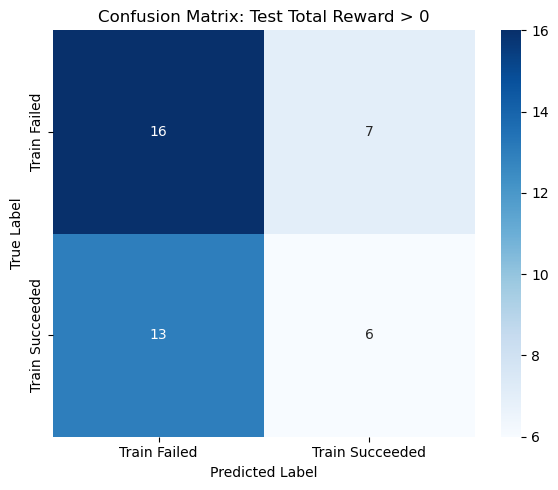

{'classification_report': {'False': {'precision': 0.5517241379310345,
   'recall': 0.6956521739130435,
   'f1-score': 0.6153846153846154,
   'support': 23.0},
  'True': {'precision': 0.46153846153846156,
   'recall': 0.3157894736842105,
   'f1-score': 0.375,
   'support': 19.0},
  'accuracy': 0.5238095238095238,
  'macro avg': {'precision': 0.506631299734748,
   'recall': 0.505720823798627,
   'f1-score': 0.4951923076923077,
   'support': 42.0},
  'weighted avg': {'precision': 0.510925855753442,
   'recall': 0.5238095238095238,
   'f1-score': 0.5066391941391941,
   'support': 42.0}},
 'confusion_matrix': [[16, 7], [13, 6]],
 'regression_mse': 2.3056747431570734,
 'regression_r2': 0.05975469888523721}

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


# Load the uploaded CSV
df = completed_runs_df.copy()

# Define features and target
feature_prefixes = ["train_resid_", "train_market_", "train_", "train_ljung_"]
exclude_cols = ["train_total_reward", "test_total_reward", "run_hash", "seed", "target_date", 
                "agent", "policy", "env_version", "train_episode_id", "test_episode_id", 
                "ticker", "environment_id", "agent_id", "market_features"]

feature_cols = [col for col in df.columns if any(col.startswith(p) for p in feature_prefixes) and col not in exclude_cols]

# Drop rows with missing values in selected columns
df_filtered = df[feature_cols + ['test_total_reward']].dropna()

# Classification label: success if test_total_reward > 0
df_filtered["is_success"] = df_filtered["test_total_reward"] > 0

# Replace inf/-inf with NaN and drop any rows with NaNs
df_cleaned = df_filtered.replace([np.inf, -np.inf], np.nan).dropna()

# Redefine X and targets
X = df_cleaned[feature_cols]
y_class = df_cleaned["is_success"]
y_reg = df_cleaned["test_total_reward"]

# Train-test split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)
y_class_pred = clf.predict(X_test)

# Train regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)

# Reports
class_report = classification_report(y_class_test, y_class_pred, output_dict=True)
conf_matrix = confusion_matrix(y_class_test, y_class_pred)
regression_mse = mean_squared_error(y_reg_test, y_reg_pred)
regression_r2 = r2_score(y_reg_test, y_reg_pred)

tools.display_dataframe_to_user("Cleaned Benchmark Dataset Sample", df_cleaned.head(10))
# Labels
labels = ["Train Failed", "Train Succeeded"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Test Total Reward > 0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
{
    "classification_report": class_report,
    "confusion_matrix": conf_matrix.tolist(),
    "regression_mse": regression_mse,
    "regression_r2": regression_r2
}

Cleaned Benchmark Dataset Sample


Loading ITables v2.4.0 from the internet... (need help?)


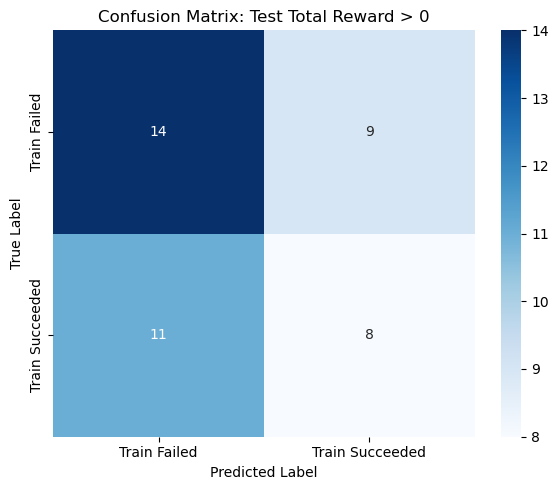

{'classification_report': {'False': {'precision': 0.56,
   'recall': 0.6086956521739131,
   'f1-score': 0.5833333333333334,
   'support': 23.0},
  'True': {'precision': 0.47058823529411764,
   'recall': 0.42105263157894735,
   'f1-score': 0.4444444444444444,
   'support': 19.0},
  'accuracy': 0.5238095238095238,
  'macro avg': {'precision': 0.5152941176470589,
   'recall': 0.5148741418764302,
   'f1-score': 0.5138888888888888,
   'support': 42.0},
  'weighted avg': {'precision': 0.5195518207282913,
   'recall': 0.5238095238095238,
   'f1-score': 0.5205026455026456,
   'support': 42.0}},
 'confusion_matrix': [[14, 9], [11, 8]],
 'regression_mse': 2.391935428079094,
 'regression_r2': 0.02457792301536088}

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from environments import AutoFeatureScaler


# Load the uploaded CSV
df = completed_runs_df.copy()

# Define features and target
feature_prefixes = ["train_resid_", "train_market_", "train_", "train_ljung_"]
exclude_cols = ["train_total_reward", "test_total_reward", "run_hash", "seed", "target_date", 
                "agent", "policy", "env_version", "train_episode_id", "test_episode_id", 
                "ticker", "environment_id", "agent_id", "market_features"]

feature_cols = [col for col in df.columns if any(col.startswith(p) for p in feature_prefixes) and col not in exclude_cols]

# Drop rows with missing values in selected columns
df_filtered = df[feature_cols + ['test_total_reward']].dropna()

# Classification label: success if test_total_reward > 0
df_filtered["is_success"] = df_filtered["test_total_reward"] > 0

# Replace inf/-inf with NaN and drop any rows with NaNs
df_cleaned = df_filtered.replace([np.inf, -np.inf], np.nan).dropna()

# Redefine X and targets
X = df_cleaned[feature_cols]
y_class = df_cleaned["is_success"]
y_reg = df_cleaned["test_total_reward"]

# Train-test split
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, random_state=42
)
scaler = AutoFeatureScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_class_train)
y_class_pred = clf.predict(X_test_scaled)

# Train regressor
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_scaled, y_reg_train)
y_reg_pred = reg.predict(X_test_scaled)

# Reports
class_report = classification_report(y_class_test, y_class_pred, output_dict=True)
conf_matrix = confusion_matrix(y_class_test, y_class_pred)
regression_mse = mean_squared_error(y_reg_test, y_reg_pred)
regression_r2 = r2_score(y_reg_test, y_reg_pred)

tools.display_dataframe_to_user("Cleaned Benchmark Dataset Sample", df_cleaned.head(10))

labels = ["Train Failed", "Train Succeeded"]

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Test Total Reward > 0")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


{
    "classification_report": class_report,
    "confusion_matrix": conf_matrix.tolist(),
    "regression_mse": regression_mse,
    "regression_r2": regression_r2
}

In [15]:
X_train.values

array([[ 1.07002334,  1.12530379,  0.16274311, ...,  0.13912166,
         0.20039332,  0.89939142],
       [ 1.2127787 ,  1.13819003,  0.09770861, ...,  0.25479673,
         0.42224391,  2.13428538],
       [ 1.19870866,  0.92674693,  0.12476612, ..., -0.10446718,
        -0.13715702, -0.50907478],
       ...,
       [ 1.35424863,  1.17736678,  0.24426934, ...,  0.16480659,
         0.3195748 ,  1.97241901],
       [ 1.36824063,  1.15169505,  0.10865277, ...,  0.190634  ,
         0.25632993,  1.01356987],
       [ 1.21314988,  1.1534485 ,  0.07918511, ...,  0.41608776,
         0.90579818,  4.52702569]])

In [16]:
ccccccc

NameError: name 'ccccccc' is not defined

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller, acf
from sklearn.linear_model import LinearRegression
from antropy import perm_entropy
from hurst import compute_Hc
from arch import arch_model

In [ ]:
def extract_market_meta_features(full_df, episode_df):
    """
    Computes meta-features using:
    - `full_df`: the extended lookback data (for features like ADF, Hurst, entropy)
    - `episode_df`: the actual trading period (for volatility, drawdown, etc.)
    """
    result = {}

    # ========== Raw returns from full padded context ==========
    pad = max(len(episode_df), 200) * -1
    close_prices = full_df['return_1d'].iloc[pad:]
    returns_full = close_prices.copy()#.pct_change().dropna()
    print(pad,returns_full)
    # Basic checks
    if len(returns_full) < 10:
        return {k: np.nan for k in [
            "entropy", "hurst", "adf_pval", "perm_entropy", "fractal_dim",
            "volatility", "max_drawdown", "skew", "kurtosis", "garch_vol",
            "acf1", "acf2", "acf5"
        ]}

    # --- Complexity (context features) ---
    result["entropy"] = -np.sum(np.histogram(returns_full, bins=20, density=True)[0] * 
                                np.log2(np.histogram(returns_full, bins=20, density=True)[0] + 1e-10))

    try:
        price_series = 100 * (1 + returns_full).cumprod()
        H, _, _ = compute_Hc(price_series.values, kind='price', simplified=True)
        result["hurst"] = H
        result["fractal_dim"] = 2 - H
    except:
        result["hurst"] = np.nan
        result["fractal_dim"] = np.nan

    try:
        result["adf_pval"] = adfuller(returns_full)[1]
    except:
        result["adf_pval"] = np.nan

    try:
        result["perm_entropy"] = perm_entropy(returns_full, normalize=True)
    except:
        result["perm_entropy"] = np.nan

    try:
        model = arch_model(returns_full * 100, vol='Garch', p=1, q=1)
        res = model.fit(disp="off")
        result["garch_vol"] = np.mean(res.conditional_volatility)
    except:
        result["garch_vol"] = np.nan

    try:
        acf_vals = acf(returns_full, nlags=5, fft=False)
        print(acf_vals)
        result["acf1"] = acf_vals[1]
        result["acf2"] = acf_vals[2]
        result["acf5"] = acf_vals[5] if len(acf_vals) > 5 else np.nan
    except:
        result["acf1"] = result["acf2"] = result["acf5"] = np.nan

    # ========== Risk/Volatility only on episode_df ==========
    returns_episode = episode_df['close'].pct_change().dropna()
    result["volatility"] = returns_episode.std()
    result["max_drawdown"] = ((episode_df['close'] / episode_df['close'].cummax()) - 1).min()
    result["skew"] = skew(returns_episode)
    result["kurtosis"] = kurtosis(returns_episode)

    return returns_full


In [ ]:
ep_tracker = EpisodeTracker()
ep = ep_tracker.findEpisode("2024-06-01","AAPL",50,mode="both")

In [ ]:
episode = ep['train']['df']
prices = episode.copy()
prices = prices.iloc[ep['train']['df_start_iloc']:]


In [ ]:
rf =extract_market_meta_features(episode,prices)
perm_entropy(rf, normalize=True)

In [35]:
prices

,id,symbol,timestamp,date,open,high,low,close,volume,trade_count,...,trade_count_change,sector_id,industry_id,return_1d,vix,vix_norm,sp500,sp500_norm,market_return_1d,month
554,33978,AAPL,2024-03-20 04:00:00,2024-03-20,175.720,178.6700,175.0900,178.67,53423102.0,641653.0,...,0.008796,10.0,unknown,0.014709,0.1304,-0.056440,52.2462,0.008904,0.008904,2024-03
555,33979,AAPL,2024-03-21 04:00:00,2024-03-21,177.050,177.4900,170.8400,171.37,106181270.0,1224985.0,...,0.909108,10.0,unknown,-0.040857,0.1292,-0.009202,52.4153,0.003237,0.003237,2024-03
556,33980,AAPL,2024-03-22 04:00:00,2024-03-22,171.760,173.0500,170.0600,172.28,71160138.0,736379.0,...,-0.398867,10.0,unknown,0.005310,0.1306,0.010836,52.3418,-0.001402,-0.001402,2024-03
557,33981,AAPL,2024-03-25 04:00:00,2024-03-25,170.565,171.9400,169.4500,170.85,54288328.0,727686.0,...,-0.011805,10.0,unknown,-0.008300,0.1319,0.009954,52.1819,-0.003055,-0.003055,2024-03
558,33982,AAPL,2024-03-26 04:00:00,2024-03-26,170.000,171.4200,169.5800,169.71,57388449.0,684303.0,...,-0.059618,10.0,unknown,-0.006673,0.1324,0.003791,52.0358,-0.002800,-0.002800,2024-03
559,33983,AAPL,2024-03-27 04:00:00,2024-03-27,170.410,173.6000,170.1100,173.31,60273265.0,670630.0,...,-0.019981,10.0,unknown,0.021213,0.1278,-0.034743,52.4849,0.008631,0.008631,2024-03
560,33984,AAPL,2024-03-28 04:00:00,2024-03-28,171.750,172.2300,170.5100,171.48,65672690.0,648027.0,...,-0.033704,10.0,unknown,-0.010559,0.1301,0.017997,52.5435,0.001117,0.001117,2024-03
561,33985,AAPL,2024-04-01 04:00:00,2024-04-01,171.190,171.2500,169.4750,170.03,46240500.0,676830.0,...,0.044447,10.0,unknown,-0.008456,0.1365,0.049193,52.4377,-0.002014,-0.002014,2024-04
562,33986,AAPL,2024-04-02 04:00:00,2024-04-02,169.080,169.3400,168.2302,168.84,49356481.0,608917.0,...,-0.100340,10.0,unknown,-0.006999,0.1461,0.070330,52.0581,-0.007239,-0.007239,2024-04
563,33987,AAPL,2024-04-03 04:00:00,2024-04-03,168.790,170.6800,168.5800,169.65,47691715.0,571286.0,...,-0.061800,10.0,unknown,0.004797,0.1433,-0.019165,52.1149,0.001091,0.001091,2024-04


In [ ]:
# Load and Prepare Data ================
ohlcv_df = OHLCV_DF.copy()


# Filter Tickers ======================
tickers = ohlcv_df['symbol'].unique()
tickers = tickers[~np.isin(tickers, excluded_tickers)]
tickers = ["AAPL"]  # Force test with AAPL
#tickers = TOP2_STOCK_BY_SECTOR
# Load and prepare trackers
ep_tracker    = EpisodeTracker()
env_tracker   = EnvironmentTracker()
agent_tracker = AgentTracker()

In [ ]:
ep = ep_tracker.findEpisode("2025-01-01","AAPL",120,"both")
train_df = ep['train']['df']

env = env_tracker.findEnvironment(
    "v4",
    {"lookback":0,
     "scaling_strategy":"auto",
     "n_timesteps":120,
     "market_features":[ "close", "price_change", "volume_change"]},
    ticker="AAPL",
    start_idx=ep['train']['df_start_iloc']
)
agent = agent_tracker.findAgent('PPO','MlpPolicy',{})

In [ ]:
ep['train']
model = agent["model"].boot(env['environment'])
model

In [ ]:
model.learn(total_timesteps=10_000)
#env['environment'].reset()

In [ ]:
env

In [ ]:
#runs = eb.run()
train_df = ep['train']['df']
eb.extract_agent_diagnostics(env['environment'],model)

In [ ]:
"""
# V4 AutoScaler =================================

# V4 ============================================
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 119      |
|    ep_rew_mean     | -0.293   |
| time/              |          |
|    fps             | 368      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -0.227       |
| time/                   |              |
|    fps                  | 375          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0039481735 |
|    clip_fraction        | 0.00503      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.69        |
|    explained_variance   | -0.107       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.146        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00425     |
|    value_loss           | 0.253        |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -0.0435     |
| time/                   |             |
|    fps                  | 344         |
|    iterations           | 3           |
|    time_elapsed         | 17          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.004291957 |
|    clip_fraction        | 0.00679     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.688      |
|    explained_variance   | 0.169       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0454     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00449    |
|    value_loss           | 0.221       |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | 0.179       |
| time/                   |             |
|    fps                  | 353         |
|    iterations           | 4           |
|    time_elapsed         | 23          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008619598 |
|    clip_fraction        | 0.0177      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0335     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00589    |
|    value_loss           | 0.206       |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | 0.386        |
| time/                   |              |
|    fps                  | 353          |
|    iterations           | 5            |
|    time_elapsed         | 28           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0033814711 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0.103        |
|    learning_rate        | 0.0003       |
|    loss                 | 9.68e-05     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00903     |
|    value_loss           | 0.169        |
------------------------------------------

{'train_total_reward': 1.8404246654035108,
 'train_wallet': 1.2311124381229703,
 'train_market': 1.2610675191320353,
 'train_resid_oracle_std': 0.1649787826127421,
 'train_resid_oracle_skew': 7.100542170671588,
 'train_resid_oracle_kurtosis': 71.28572593394061,
 'train_resid_oracle_acf1': -0.03614584193924006,
 'train_resid_oracle_mean': -6.761922913547766e-05,
 'train_resid_oracle_median': -0.0005808469933746441,
 'train_resid_oracle_max': 1.5933017925434414,
 'train_resid_oracle_min': -0.4090312514457644,
 'train_ljung_oracle_pval': 0.43397976725966475,
 'train_resid_market_std': 0.004207810947213421,
 'train_resid_market_skew': 3.914946935632663,
 'train_resid_market_kurtosis': 19.557611931096172,
 'train_resid_market_acf1': 0.6085714183637173,
 'train_resid_market_mean': -0.004342682837053663,
 'train_resid_market_median': -0.006046241177076084,
 'train_resid_market_max': 0.022354143814353078,
 'train_resid_market_min': -0.006476324087659302,
 'train_ljung_market_pval': 4.222512971005281e-58,
 'train_sharpe': 0.09010650230498658,
 'train_sortino': 0.32005405023559785,
 'train_calmar': 1.8007265566029227,
 'train_market_sharpe': 0.09126171812151522,
 'train_market_sortino': 0.32781071367581516,
 'train_market_calmar': 1.8345812189354533}
<stable_baselines3.ppo.ppo.PPO at 0x18822e54a90>
"""

In [ ]:
xxxx

In [ ]:
pddf= pd.DataFrame(runs)
pddf['train_episode_id'],pddf['test_episode_id']

In [ ]:
cols_to_drop = [col for col in pddf.columns if col.startswith('test_') and col != 'test_total_reward']
pddf_cleaned = pddf.drop(columns=cols_to_drop)

# Now you can compute correlation
correlations = pddf_cleaned.corr(numeric_only=True)['test_total_reward'].sort_values(ascending=False)
correlations

In [ ]:
pddf[['train_wallet','test_wallet','train_market','test_market','test_total_reward',"train_total_reward",
"train_sortino"                  ,
"train_calmar"                   ,
"train_resid_market_acf1"        ,
"train_resid_oracle_kurtosis"    ,
"train_sharpe"                   ,
"train_resid_oracle_max"         ]]

In [ ]:
ppdf['train_episode_id']